In [2]:
%pip install -qq -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ecg_plot

from scipy import optimize

import tensorflow as tf
import keras
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import Dataset, DataLoader

In [4]:
st_petersburg_incart_12lead_arrhythmia_database_path = r'data/china-12lead-ecg-challenge-database'
ptbxl_electrocardiography_database_path = r'data/ptbxl_electrocardiography_database'
ptb_diagnostic_ecg_database_path = r'data/ptb_diagnostic_ecg_database'
china_physiological_signal_challenge_in_2018_path = r'data/china_physiological_signal_challenge_2018'
china_12lead_ecg_challenge_database_path = r'data/china_12lead_ecg_challenge_database'
physionet_snomed_mappings_path = r'data/physionet_snomed_mappings'
physionet_challenge_models_path = r'datas/physionet_challenge_models'
georgia_12lead_ecg_challenge_database_path = r'data/georgia_12lead_ecg_challenge_database'
physionet_challenge_utility_script_patched_v2 = r'utils/physionet_challenge_utility_script_patched_v2.py'

In [5]:
import sys
import os

# Add the directory to sys.path
sys.path.append(os.path.dirname(physionet_challenge_utility_script_patched_v2))

# Optionally set the working directory (only if needed)

os.chdir("..")
print("Now in:", os.getcwd())


Now in: c:\Users\nares\Documents\cvd-early-detection-ecg-uhull


In [6]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

import physionet_challenge_utility_script_patched_v2 as pc

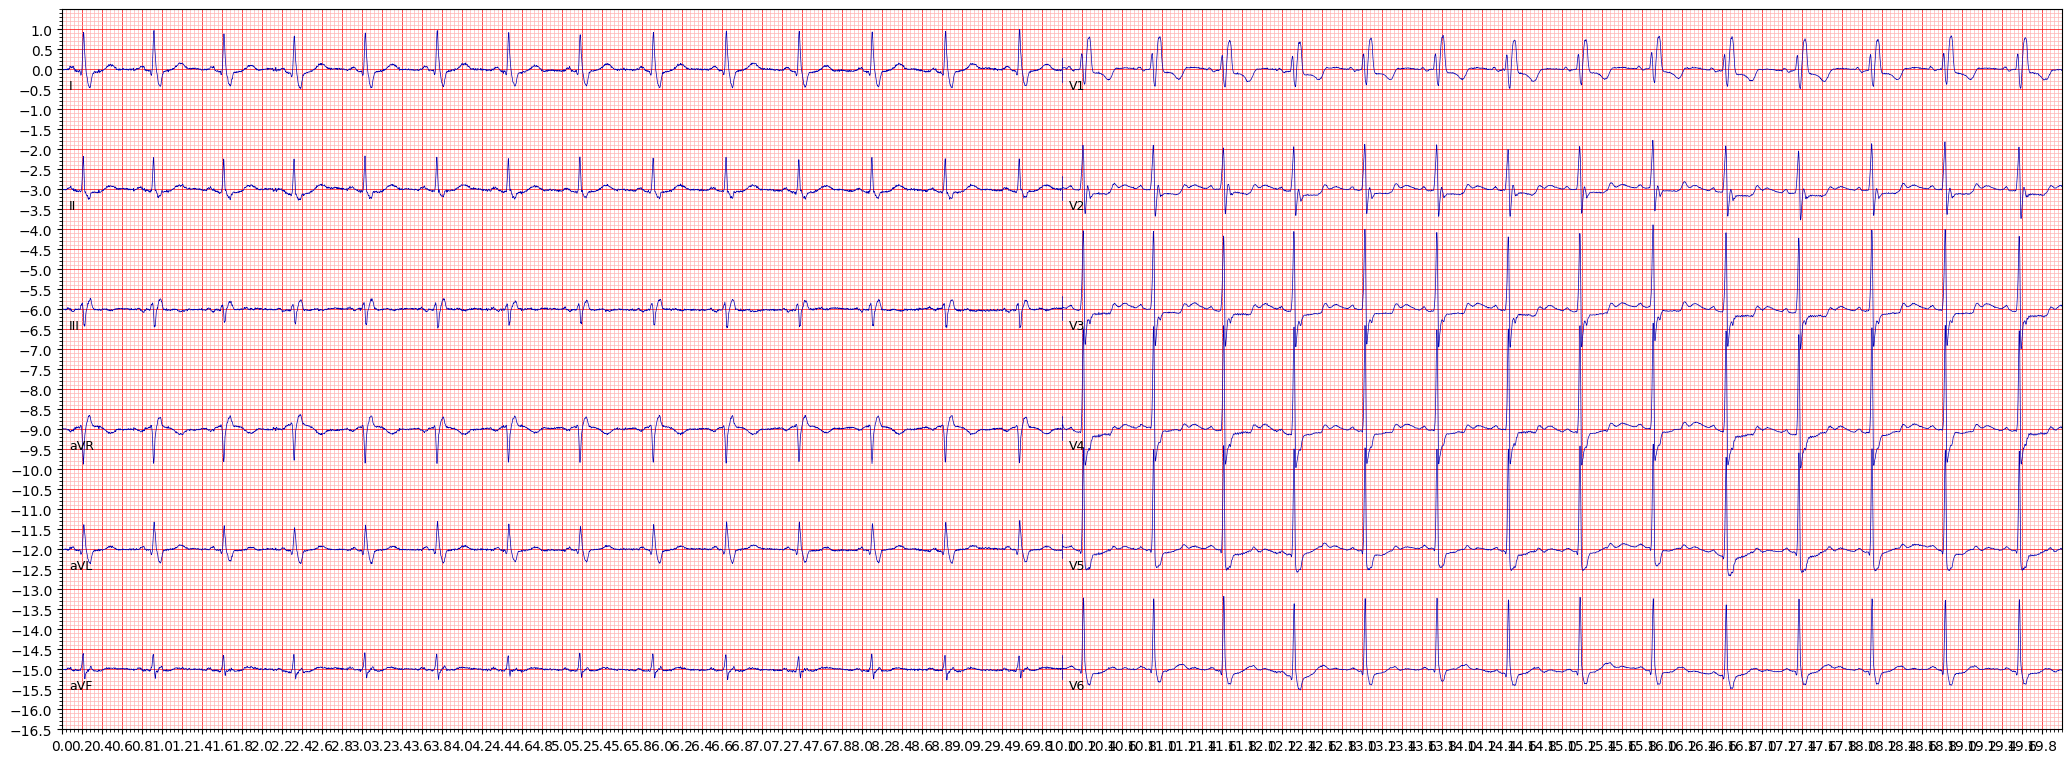

In [7]:
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()

plot_ecg('data/china-12lead-ecg-challenge-database/Training_2/Q0948.mat') 

In [8]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Load data
gender, age, labels, ecg_filenames = pc.import_key_data("data")
labels = np.asarray(labels)

In [9]:
print(ecg_filenames[0])

data\china-12lead-ecg-challenge-database\Training_2\Q0001.mat


In [ ]:
# Clean filenames for wfdb
def clean_record_path(fullpath):
    return os.path.splitext(fullpath)[0]  # removes .mat

record_paths = [clean_record_path(p) for p in ecg_filenames]

In [11]:
import torch
from torch.utils.data import Dataset
import numpy as np
import wfdb

class PhysioNetECGDataset(Dataset):
    def __init__(self, record_paths, labels, seq_len=500, leads=[0], normalize=True):
        """
        Args:
            record_paths: list of cleaned full paths (e.g., data/.../Q0001 — no .mat)
            labels: list of labels (strings or ints)
            seq_len: number of time steps to pad/truncate to
            leads: list of integers for ECG lead indices (e.g., [0] for lead I)
            normalize: whether to apply z-score normalization per sample
        """
        self.record_paths = record_paths
        self.labels = labels
        self.seq_len = seq_len
        self.leads = leads
        self.normalize = normalize

    def __len__(self):
        return len(self.record_paths)

    def _load_signal(self, path):
        try:
            record = wfdb.rdrecord(path)
        except FileNotFoundError:
            raise FileNotFoundError(f"Missing WFDB files for record: {path}\nExpected: {path}.hea and {path}.dat")

        signal = record.p_signal[:, self.leads]  # Shape: (T, n_leads)

        # Pad or truncate to fixed length
        if signal.shape[0] < self.seq_len:
            pad_len = self.seq_len - signal.shape[0]
            signal = np.vstack([signal, np.zeros((pad_len, len(self.leads)))])
        else:
            signal = signal[:self.seq_len, :]

        # Normalize each lead (channel) independently
        if self.normalize:
            mean = np.mean(signal, axis=0)
            std = np.std(signal, axis=0)
            std[std == 0] = 1  # avoid division by zero
            signal = (signal - mean) / std

        return torch.tensor(signal, dtype=torch.float32)  # Shape: (seq_len, n_leads)

    def __getitem__(self, idx):
        signal = self._load_signal(self.record_paths[idx])
        label = self.labels[idx]
        return signal, torch.tensor(label, dtype=torch.long)


In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [22]:
dataset = PhysioNetECGDataset(
    record_paths=record_paths,
    labels=labels_encoded,
    seq_len=500,
    leads=[0],          # single-lead input
    normalize=True
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

This is alternative, always use alternative for now.

In [ ]:
from scipy.io import loadmat
from torch.utils.data import Dataset
import numpy as np
import torch

class MatECGDataset(Dataset):
    def __init__(self, mat_paths, labels, seq_len=500, leads=[0], normalize=True):
        self.mat_paths = mat_paths              # .mat file paths
        self.labels = labels                    # integer-encoded labels
        self.seq_len = seq_len
        self.leads = leads                      # ECG leads to use (e.g., [0] for Lead I)
        self.normalize = normalize

    def __len__(self):
        return len(self.mat_paths)

    def _load_signal(self, path):
        mat = loadmat(path)
        ecg = mat['val'].T                      # Shape: (T, 12) → 12-lead ECG

        signal = ecg[:, self.leads]             # Select lead(s), shape: (T, len(leads))

        # Pad or truncate
        if signal.shape[0] < self.seq_len:
            pad = np.zeros((self.seq_len - signal.shape[0], len(self.leads)))
            signal = np.vstack([signal, pad])
        else:
            signal = signal[:self.seq_len, :]

        if self.normalize:
            mean = np.mean(signal, axis=0)
            std = np.std(signal, axis=0)
            std[std == 0] = 1
            signal = (signal - mean) / std

        return torch.tensor(signal, dtype=torch.float32)

    def __getitem__(self, idx):
        signal = self._load_signal(self.mat_paths[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return signal, label


In [ ]:
# Use original ecg_filenames list with .mat files
dataset = MatECGDataset(
    mat_paths=ecg_filenames,      # .mat paths as collected
    labels=labels_encoded,        # integer-encoded labels from LabelEncoder
    seq_len=500,
    leads=[0],                    # or multiple, e.g., [0, 1, 2]
    normalize=True
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [24]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class ECGTransformer(nn.Module):
    def __init__(self, input_dim=1, seq_len=500, d_model=64, nhead=4, num_layers=2, num_classes=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * seq_len, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)           # (B, seq_len, d_model)
        x = self.pos_encoder(x)         # + positional encoding
        x = self.encoder(x)             # (B, seq_len, d_model)
        return self.classifier(x)       # (B, num_classes)

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ECGTransformer(
    input_dim=1,
    seq_len=500,
    d_model=64,
    nhead=4,
    num_layers=2,
    num_classes=len(label_encoder.classes_)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [26]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss / len(dataloader), acc

In [27]:
for epoch in range(1, 2):
    loss, acc = train_one_epoch(model, dataloader, optimizer, criterion)
    print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

Epoch 1: Loss = 6.8104, Accuracy = 0.2014
